 
## Objective: 
- Replicate deep learning models from PubMed 200k RCT: a dataset for Sequential Sentence Classification in Medical Abstracts.
        - https://arxiv.org/abs/1710.06071
        
    - Model is expected to transform regular abstracts to classified abstracts by predicting the section label for each sentence.


## Experiment Steps
- Download a text dataset (PubMed 200k RCT)
- Write a preprocessing function for the text data
- Set up multiple modeling experiments with different levels of embeddings
- Build a multimodal model to take in different sources of data
    - model replicates the architecture from 
        - https://arxiv.org/pdf/1612.05251.pdf
- Evaluate model on most wrong predictions
- Make predictions on PubMed abstacts from the wild 

## Import Tools

In [1]:
import tensorflow as tf 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import datetime
import sklearn
import time
import helper_functions
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2023-05-21 20:35:55.683862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

- Dataset is available at 
    - https://github.com/Franck-Dernoncourt/pubmed-rct

### Clone and View available files

In [2]:
#!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir+file for file in os.listdir(data_dir)]
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt   test.txt  train.txt


## Preprocess Data

In [3]:
def get_lines(filename):

    ''' Reads text file path and returns the text in a list'''
    
    with open(filename, "r") as f:
        return f.readlines()   

In [4]:
def preprocess_text_with_line_numbers(filename):
    
    '''
    Reads the given text file path and returns a list of dictionaries 
    for each abstract's sentences including their
    
    
    - the classified label, target
    - the sentence, text
    - line number in abstract
    - total lines in abstract
    
    
    ex. {"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}
    
    '''
    
    lines = get_lines(filename) # reads text file path and returns the text in a list
    abs_lines = "" # empty abstract to store abstract contents
    text_list = [] # empty list to store abstracts


    for item in (lines):

        if item.startswith("###"):  # checks if line is ID for new abstract
            abs_lines = "" # empties out abstract string


        elif item == ("\n"): # checks if line is a new line
 
            for num, lines in enumerate(abs_lines.splitlines()): #split into individual numbered lines
                target, text = lines.split("\t") #separate line into label and sentence

                dict = {
                "target":target, #store label 
                "text" : text.lower(), #store sentence
                "line_number": num, # store line number
                "total_lines":len(abs_lines.splitlines())-1 #store total sentences
                 }

                text_list.append(dict) # add abstract details to text list



        else:  # if line isn't an ID or new line
         abs_lines += item #store lines in empty abstract
 
 
    return text_list 

### Preprocess and store samples in Pandas Dataframe

In [5]:
#preprocess samples
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

#store samples in DF
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
 

### Create lists of Train, Validation and Test Sentence's  Words and Characters

In [6]:
#list of words 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

#list of characters
train_chars = [" ".join(list(sentence)) for sentence in train_sentences]
val_chars = [" ".join(list(sentence)) for sentence in val_sentences]
test_chars = [" ".join(list(sentence)) for sentence in test_sentences]

### Convert targets to Numerical Data using Sklearn
   - One hot encode 
   - Label encode

### One hot encode

In [7]:
#import one hot encoder
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape([-1,1]))

/Users/suranjitmohajan/anaconda3/envs/py3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Label encode

In [8]:
#import label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

### Class names and number of classes

In [9]:
class_names = label_encoder.classes_
num_classes = len(label_encoder.classes_)

## Data exploration
- Word level
- Character level
- Position level

## Word level exploration

#### Find the average number of words per sentence 

In [15]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sen_len = round(np.mean(sent_lens))

#### Observation: 
- Average sentence has about 26 words

#### Distribution of sentence lengths


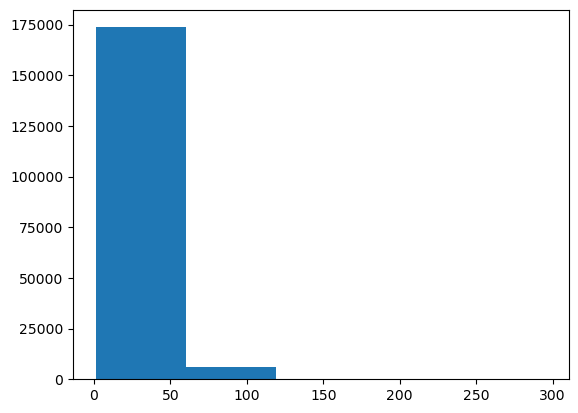

In [16]:
 plt.hist(sent_lens, bins=5);

In [17]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

#### Observation: 
- Majority of the sentences are below 50 words
- 95 percent of sentences have between 0-55 words


## Character level exploration

#### Find the average number of characters per sentence 

In [18]:
char_lens = [len(sentence) for sentence in train_sentences]
avg_char_len = round(np.mean(char_lens))

#### Observation: 
- Average sentence has about 149 characters

#### Distribution of sentence lengths


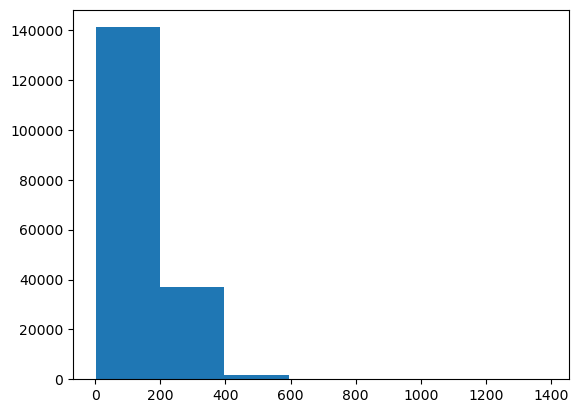

In [19]:
plt.hist(char_lens, bins = 7);

In [20]:
output_chars_len = int(np.percentile(char_lens, 95))
output_chars_len

290

#### Observation: 
- Majority of the sentences are below 500 characters
- 95 percent of sentences have between 0-290 characters

## Positional level exploration

### Text line number
- how many different line numbers in the dataframe?
- check data distribution
    

In [21]:
train_df.line_number.value_counts()
np.percentile(train_df.line_number, 98)

15.0

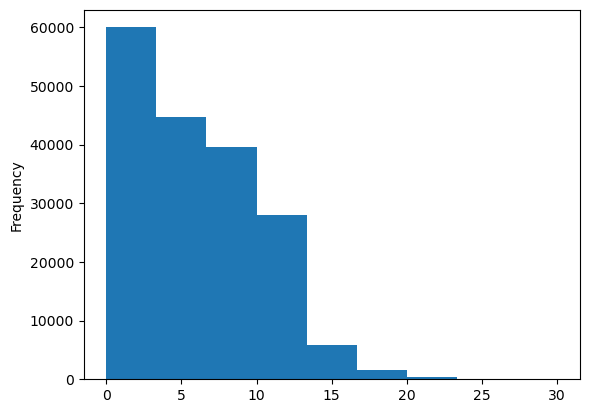

In [22]:
train_df.line_number.plot.hist(bins=9);

### Observation: 
- 98% of the text have an index of 15 or less sentences.


### Total lines number
- how many different total line numbers in the dataframe?
- check data distribution
   

In [23]:
train_df.total_lines.value_counts()
np.percentile(train_df.total_lines, 98)

20.0

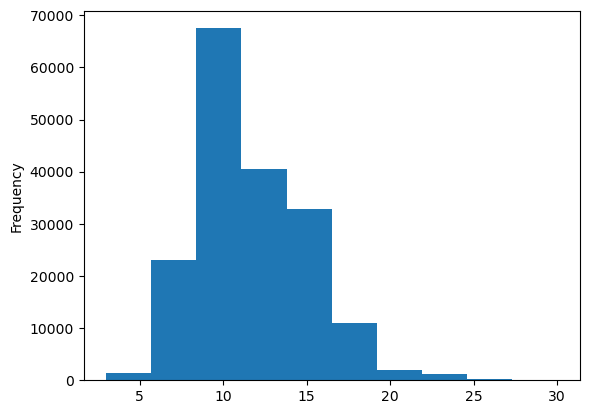

In [24]:
train_df.total_lines.plot.hist();

### Observation: 
- 98% of the abstracts have a total of 20 lines


## Convert inputs to Numerical Data 
- pubmed 20k
    - positional level
        - line number
        - total lines
    - word level
        - text's words
    - character level
        - text's characters

### Positional level - line number - one hot encode

In [25]:
train_line_number_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)


2023-04-01 19:33:07.580969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Positional level - total lines - one hot encode

In [26]:
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)


## Word level - Text Vectorization 

#### Instantiate and adapt text vectorizer

- How many words are in our vocabulary? 
   -  max_tokens | V | 68,000
   - taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf
    
- How many words in the output seq?
    - 55, from the 95% percentile


In [27]:
max_tokens = 68000
 
from tensorflow.keras.layers.experimental.preprocessing import  TextVectorization


text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                   output_mode = "int",
                                   output_sequence_length = output_seq_len,
                                   name= "text_vectorizer"
                                   )
                                    
text_vectorizer.adapt(train_sentences)                       
                                    

## Character level - Text Vectorization 

#### Instantiate and adapt char vectorizer

   - How many characters are in our vocabulary? -  max_tokens 
       - length of
           - alphabet
           - digits
           - punctuations
       - space and OOV
     
   - How many characters in the output seq?
    - 290, from the 95% percentile


In [28]:
import string
max_chars=len(string.ascii_lowercase + string.digits + string.punctuation) + len(" ") + len(["OOV"])   

In [29]:
max_tokens = max_chars
output_seq_len = output_chars_len
 
from tensorflow.keras.layers.experimental.preprocessing import  TextVectorization


char_vectorizer = TextVectorization(max_tokens = max_tokens,
                                   output_mode = "int",
                                   output_sequence_length = output_seq_len, 
                                   standardize = "lower_and_strip_punctuation",
                                   name= "char_vectorizer"
                                   )
                                    
char_vectorizer.adapt(train_chars)                       
                                    

### Tokenize Sample Sentence


In [30]:
target_sentence = random.choice(train_sentences)
print(f"Original random sentence: \n'{target_sentence}' " )
print(f"\nLength of Original random sentence: {len(target_sentence.split())} " )
print(f"\nText Vectorized random sentence: \n '{text_vectorizer([target_sentence])}' ")      

Original random sentence: 
'suboptimal vitamin d status is highly prevalent in northern communities , particularly in those patients with chronic diseases such as diabetes and chronic renal disease .' 

Length of Original random sentence: 26 

Text Vectorized random sentence: 
 '[[3274  412  187  272   20  862 1998    5 5724 2566 1057    5  125   12
     7  244 1298  345   25  223    3  244  474  114    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]' 



### Characterize Sample Sentence

In [31]:
target_sentence = random.choice(train_sentences)
print(f"Original random sentence: \n{target_sentence} " )
print(f"\nLength of Original random sentence: {len(target_sentence.split())} " )
print(f"\nChar Vectorized random sentence: \n '{char_vectorizer([target_sentence])}' ")
        

Original random sentence: 
all participants were fitted with the four different simcls ( air optix aqua multifocal -lsb- aoam ; alcon -rsb- , purevision multifocal -lsb- pm ; bausch & lomb -rsb- , acuvue oasys for presbyopia -lsb- aop ; johnson & johnson vision -rsb- , and biofinity multifocal -lsb- bm ; coopervision -rsb- ) and with monofocal contact lenses ( air optix aqua , alcon ) . 

Length of Original random sentence: 65 

Char Vectorized random sentence: 
 '[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0

### Explore tokens in vocabulary

In [32]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Total number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words {rct_20k_text_vocab[:5]}")
print(f"Least common words {rct_20k_text_vocab[-5:]}")

Total number of words in vocab: 64841
Most common words ['', '[UNK]', 'the', 'and', 'of']
Least common words ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Explore characters in vocabulary

In [33]:
rct_20k_char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(rct_20k_char_vocab)}")
print(f"5 most common characters: {rct_20k_char_vocab[:5]}")
print(f"5 least common characters: {rct_20k_char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


###  Text Vectorizer Configurations

In [34]:
text_vectorizer.get_config()

{'name': 'text_vectorizer',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

###  Character Vectorizer Configurations

In [35]:
char_vectorizer.get_config()    

{'name': 'char_vectorizer',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 70,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 290,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

## Embedding

- Token level embedding
- Character lebel embedding

### Token Level Embedding

In [122]:
from tensorflow.keras import layers

token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), #input shape
                               output_dim = 128, #output_shape
                               input_length = output_seq_len,  #how long is each input
                               mask_zero = True,
                               name = "token_embedding"
                              )


### Character Level Embedding

   - output_dim = 25
       - from SkimLit paper. https://arxiv.org/pdf/1710.06071.pdf

In [126]:
char_embed = layers.Embedding(input_dim = max_chars, #input shape
                               output_dim = 25, #output_shape
                               input_length = output_chars_len,  #how long is each input
                               mask_zero = False,
                               name = "char_embedding"
                              )


### Embed Sample Sentence

In [39]:
sample_sentence = "There's a flood in my street"

print(f"Sentence before vectorization: \n{sample_sentence} \n")
vectorized_sentence = text_vectorizer([sample_sentence])
print(f"Sentence after vectorization: \n{vectorized_sentence} \n")

#random_sentence = random.choice(train_sentences)
#print(text_vectorizer(random_sentence))

embedded_sentence = token_embed(text_vectorizer([sample_sentence]))
print(f"Sentence after embedding: \n{embedded_sentence} \n")

print(f" Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
There's a flood in my street 

Sentence after vectorization: 
[[43871     8     1     5 25624 10148     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]] 

Sentence after embedding: 
[[[ 0.03745996  0.04264956  0.04706064 ... -0.01963761  0.01389814
    0.03068007]
  [-0.0258879  -0.0215438  -0.04783794 ... -0.01898686  0.01393313
    0.02954478]
  [ 0.03044387  0.04087231  0.03409256 ...  0.01262671 -0.04493991
   -0.02356706]
  ...
  [ 0.02045831  0.03747478  0.02605871 ... -0.02147753  0.03577201
   -0.04950079]
  [ 0.02045831  0.03747478  0.02605871 ... -0.02147753  0.03577201
   -0.04950079]
  [ 0.02045831  0.03747478  0.02605871 ... -0.02147753  0.03577201
   -0.04950079]]] 

 Embedded sentence shape: (

### Embed Sample Sentence's characters

In [40]:
sample_sentence = "There's a flood in my street"

print(f"Sentence before vectorization: \n{sample_sentence} \n")
vectorized_sentence_chars = char_vectorizer([sample_sentence])
print(f"Sentence after vectorization: \n{vectorized_sentence_chars} \n")
 

embedded_sentence_chars = char_embed(vectorized_sentence_chars)
print(f"Sentence after embedding: \n{embedded_sentence_chars} \n")

print(f" Embedded sentence character's shape: {embedded_sentence_chars.shape}")

Sentence before vectorization: 
There's a flood in my street 

Sentence after vectorization: 
[[1 5 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]] 

Sentence after embedding: 
[[[-0.00888432 -0.01705568 -0.00618298 ...  0.00263994 -0.01802511
   -0.04287549]
  [ 0.03050864  0.02908884  0.00842325 ...  0.03529463  0.02666577
   -0.00014519]
  [-0.00888432 -0.01705568 -0.00618298 ...  0.00263994 -0.01802511
   -0.04287549]
  ...
  [-0.00048314 -0.0069

## Running a Series of Experiments

0. Naive Bayes with TF-IDF encoder (baseline)

1. Conv1D with token embeddings

2. Feature Extraction with pre trained token embeddings 

3. Conv1d with character embeddings

4. Combination of model 2 and model 3
   - pretrained token embedding (model 2)
   - character embedding (model 3)
    
5. Tribrid Model, combination of model 4 and positional embeddings
   - pretrained token embedding (USE)
   - character embeddings 
   - positional embeddings
       - line number
       - total lines
 

## Creating Datasets 

- Steps to speed up model's data processing time by turning data to 
     - datasets
     - batches
     - prefetched

### Key note:
- Train data is not shuffled here because we want the model to learn the order of samples (objective, background, methods...etc)

### Data Performace Boost Guides
- https://www.tensorflow.org/guide/data
- https://www.tensorflow.org/guide/data_performance

## Datasets Token Level 
- used for Model 1

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices(
(tf.constant(train_sentences), 
 tf.constant(train_labels_one_hot))).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(
(tf.constant(val_sentences), 
 tf.constant(val_labels_one_hot))).batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(
(tf.constant(test_sentences), 
 tf.constant(test_labels_one_hot))).batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

## Datasets Character Level
- used for Model 3

In [42]:
train_char_dataset = tf.data.Dataset.from_tensor_slices(
(tf.constant(train_chars), 
 tf.constant(train_labels_one_hot))).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices(
(tf.constant(val_chars), 
 tf.constant(val_labels_one_hot))).batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

test_char_dataset = tf.data.Dataset.from_tensor_slices(
(tf.constant(test_chars), 
 tf.constant(test_labels_one_hot))).batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

## Datasets Token and Character Level
- used for Model 4

### Create Datasets

   - sentences & characters 
   - labels
  
### Combine Datasets

   - Zip
   - Batch 
   - Prefetch

In [43]:
# Train Data

train_char_token_data = tf.data.Dataset.from_tensor_slices(
(tf.constant(train_sentences), tf.constant(train_chars))
)

train_char_token_labels = tf.data.Dataset.from_tensor_slices(
tf.constant(train_labels_one_hot)
)


train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,
                     train_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)




# Validation Data

val_char_token_data = tf.data.Dataset.from_tensor_slices(
(tf.constant(val_sentences), tf.constant(val_chars))
)


val_char_token_labels = tf.data.Dataset.from_tensor_slices(
tf.constant(val_labels_one_hot)
)


val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, 
                     val_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

## Datasets Token, Character and Positional Level
- used for Model 5

### Create Datasets

   - sentences, characters, line number, total lines 
   - labels
  
### Combine Datasets

   - Zip
   - Batch 
   - Prefetch

In [44]:
#train_token_char_pos_data
train_token_char_pos_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_sentences),
               tf.constant(train_chars),
               tf.constant(train_line_number_one_hot),
               tf.constant(train_total_lines_one_hot)))

#train_token_char_pos_labels 
train_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(tf.constant(train_labels_one_hot))

# zip data & labels dataset
train_token_char_pos_dataset = tf.data.Dataset.zip((train_token_char_pos_data, train_token_char_pos_labels))

# batch & prefetch dataset
train_token_char_pos_dataset = train_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [45]:
#val_token_char_pos_data
val_token_char_pos_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_sentences),
               tf.constant(val_chars),
               tf.constant(val_line_number_one_hot),
               tf.constant(val_total_lines_one_hot)))

#val_token_char_pos_labels 
val_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(tf.constant(val_labels_one_hot))


# zip data & labels dataset
val_token_char_pos_dataset = tf.data.Dataset.zip((val_token_char_pos_data, val_token_char_pos_labels))

# batch & prefetch dataset
val_token_char_pos_dataset = val_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [46]:
#test_token_char_pos_data
test_token_char_pos_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_sentences),
               tf.constant(test_chars),
               tf.constant(test_line_number_one_hot),
               tf.constant(test_total_lines_one_hot)))

#test_token_char_pos_labels 
test_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(tf.constant(test_labels_one_hot))


# zip data & labels dataset
test_token_char_pos_dataset = tf.data.Dataset.zip((test_token_char_pos_data, test_token_char_pos_labels))

# batch & prefetch dataset
test_token_char_pos_dataset = test_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



## Model 0
### Naive Bayes with TF-IDF encoder - Baseline Model 

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


#Create tokenization and modelling pipeline 
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), #convert words to numbers
    ("clf", MultinomialNB()) #model the text
        
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

### Evaluate Model 0

In [48]:
from helper_functions import calculate_results

baseline_score = model_0.score(val_sentences, val_labels_encoded)
baseline_preds = model_0.predict(val_sentences)
baseline_results = calculate_results(val_labels_encoded, baseline_preds)

In [49]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1

### Conv1D with token embeddings
 


In [50]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
print(inputs.shape)

x = text_vectorizer(inputs)
print(x.shape)

x = token_embed(x)
print(x.shape)

x = layers.Conv1D(filters = 64,
                 kernel_size = 5,
                 padding = "same",
                 activation = "relu")(x)
print(x.shape)

x = layers.GlobalAveragePooling1D()(x) 
print(x.shape)

outputs = layers.Dense(num_classes, activation= "softmax")(x)
print(outputs.shape)

model_1 = tf.keras.Model(inputs, outputs, name = "model_1_conv1d")

model_1.summary()

(None, 1)
(None, 55)
(None, 55, 128)
(None, 55, 64)
(None, 64)
(None, 5)
Model: "model_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorizer (TextVector  (None, 55)               0         
 ization)                                                        
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                             

### Compile Model 1

In [51]:
model_1.compile(loss= "categorical_crossentropy",
               optimizer = "Adam",
               metrics = "accuracy")

### Fit Model 1

In [52]:
model_1_history = model_1.fit(train_dataset,
                         epochs=3,
                         steps_per_epoch=int(0.1 * len(train_dataset)),     
                         validation_data=val_dataset,
                         validation_steps = int(0.1 * len(val_dataset))       
                         )

Epoch 1/3
562/562 [==============================] - 8s 14ms/step - loss: 0.9163 - accuracy: 0.6380 - val_loss: 0.6929 - val_accuracy: 0.7350
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6647 - accuracy: 0.7526 - val_loss: 0.6377 - val_accuracy: 0.7670
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.6208 - accuracy: 0.7728 - val_loss: 0.5964 - val_accuracy: 0.7852


### Evaluate Model 1

In [53]:
model_1_score = model_1.evaluate(val_dataset)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_preds = np.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(val_labels_encoded, model_1_preds)

945/945 [==============================] - 2s 2ms/step


In [54]:
model_1_results

{'accuracy': 78.6144578313253,
 'precision': 0.7825799788028602,
 'recall': 0.786144578313253,
 'f1': 0.7834395967472083}

## Model 2

- Tensorflow Hub Pretrained Feature Extractor


### Key Note:
- The PubMed RCT paper used GloVe embeddings as their pretrained feature extractor. 
- Here, a more recent pretrained word embedding from TensorFlow Hub is used. 
    - Universal Sentence Encoder (USE).
     - https://tfhub.dev/google/universal-sentence-encoder/4


### Create Universal Sentence Encoder Instance for Model 2

In [55]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

### Build Model 2 

In [56]:
from tensorflow.keras import layers

inputs = layers.Input(shape = [], dtype="string")
print(inputs.shape)

x = tf_hub_embedding_layer(inputs)
 
x = tf.keras.layers.Dense(128, activation = "relu")(x)
print(x.shape)

outputs = tf.keras.layers.Dense(5, activation = "softmax")(x)
print(outputs.shape)

model_2 = tf.keras.Model(inputs, outputs, name = "model_2_USE")

model_2.summary()

(None,)
(None, 128)
(None, 5)
Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


### Compile Model 2

In [57]:
model_2.compile(loss= "categorical_crossentropy",
               optimizer = "Adam",
               metrics = "accuracy")

### Fit Model 2

In [58]:
model_2_history = model_2.fit(train_dataset,
                         epochs=3,
                         steps_per_epoch=int(0.1 * len(train_dataset)),     
                         validation_data=val_dataset,
                         validation_steps = int(0.1 * len(val_dataset))       
                         )

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 0.9147 - accuracy: 0.6506 - val_loss: 0.7972 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 0.7687 - accuracy: 0.7017 - val_loss: 0.7548 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 4s 6ms/step - loss: 0.7511 - accuracy: 0.7130 - val_loss: 0.7376 - val_accuracy: 0.7164


### Evaluate Model 2

In [59]:
model_2_score = model_2.evaluate(val_dataset)
model_2_pred_probs = model_2.predict(val_dataset)
model_2_preds = np.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(val_labels_encoded, model_2_preds)

945/945 [==============================] - 5s 5ms/step


In [60]:
model_2_results

{'accuracy': 71.50470011915795,
 'precision': 0.7155366890795302,
 'recall': 0.7150470011915795,
 'f1': 0.7122084892537629}

## Model 3

- Conv1d with character embeddings 

In [61]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
print(inputs.shape)

x = char_vectorizer(inputs)
print(x.shape)
 
x = char_embed(x)
print(x.shape)

x = layers.Conv1D(filters = 64,
                 kernel_size = 5,
                 padding = "same",
                 activation = "relu")(x)
print(x.shape)

x = layers.GlobalMaxPooling1D()(x) 
print(x.shape)

outputs = layers.Dense(num_classes, activation= "softmax")(x)
print(outputs.shape)

model_3 = tf.keras.Model(inputs, outputs, name = "model_3_conv1d_char_embeded")

model_3.summary()

(None, 1)
(None, 290)
(None, 290, 25)
(None, 290, 64)
(None, 64)
(None, 5)
Model: "model_3_conv1d_char_embeded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                              

### Compile Model 3

In [62]:
model_3.compile(loss= "categorical_crossentropy",
               optimizer = "Adam",
               metrics = "accuracy")

### Fit Model 3

In [63]:
model_3.fit(train_char_dataset,
                         epochs=3,
                         steps_per_epoch=int(0.1 * len(train_char_dataset)),     
                         validation_data=val_char_dataset,
                         validation_steps = int(0.1 * len(val_char_dataset))       
                         )

Epoch 1/3
562/562 [==============================] - 4s 7ms/step - loss: 1.2756 - accuracy: 0.4770 - val_loss: 1.0510 - val_accuracy: 0.5761
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0150 - accuracy: 0.5934 - val_loss: 0.9531 - val_accuracy: 0.6287
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9355 - accuracy: 0.6313 - val_loss: 0.8746 - val_accuracy: 0.6626


### Evaluate Model 3

In [64]:
model_3_score = model_3.evaluate(val_char_dataset)
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = np.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(val_labels_encoded, model_3_preds)

945/945 [==============================] - 2s 3ms/step


In [65]:
model_3_results

{'accuracy': 65.13305971137297,
 'precision': 0.65443219447858,
 'recall': 0.6513305971137296,
 'f1': 0.6437879476104023}

## Model 4

- Multimodal model, takes token and character level sequences as input
   - pretrained token embeddings (model_2)
   - character level embedding (model_3)
- Updates token and chracter embeddings, and parameters using bidirectional LSTM
- for regularization, dropout layer of 0.5 is applied.


### Key Note: 

- According to Section 4.2 of Skimlt Paper, model was trained on the Stochatic gradient descent optimizer. However, Model 4 has yielded better results using the Adam optimizer. 
    
 
 

###  Pretrained Token embedding model

In [66]:
token_inputs = layers.Input(shape = [], dtype="string")
print(token_inputs.shape)

x = tf_hub_embedding_layer(token_inputs)
print(x.shape)

token_outputs = layers.Dense(128, activation = "relu")(x)
print(token_outputs.shape)

token_model = tf.keras.Model(token_inputs, token_outputs, name = "token_model_USE")
token_model.summary()

(None,)
(None, 512)
(None, 128)
Model: "token_model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
Total params: 256,863,488
Trainable params: 65,664
Non-trainable params: 256,797,824
_________________________________________________________________


### Character embedding model

In [ ]:
char_inputs = layers.Input(shape=(1,), dtype="string")
print(char_inputs.shape)

x = char_vectorizer(char_inputs)
print(x.shape)

x = char_embed(x)
print(x.shape)


char_outputs = layers.Bidirectional(layers.LSTM(25))(x)
print(x.shape)

char_model = tf.keras.Model(char_inputs, char_outputs, name = "char_model_bd_lstm")
char_model.summary()


### Concat, dropout and adjust Model Outputs

In [68]:
token_char_model_concat = layers.Concatenate(name = "token_char_concat")([token_model.output,
                                               char_model.output])
token_char_model_concat.shape


concat_models_dropout_1 = layers.Dropout(0.5)(token_char_model_concat)
concat_models_dropout_1.shape

x = layers.Dense(200, activation = "relu")(concat_models_dropout_1)
print(x.shape)

concat_models_dropout_2 = layers.Dropout(0.5)(x)
print(concat_models_dropout_2.shape)


output_layer = layers.Dense(num_classes, activation = "softmax")(concat_models_dropout_2)


model_4 = tf.keras.Model([token_model.input, char_model.input], output_layer, name = "model_4_token_char_embedding_USE")

model_4.summary()


(None, 200)
(None, 200)
Model: "model_4_token_char_embedding_USE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_5[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512

### Compile Model 4

In [69]:
model_4.compile(loss = "categorical_crossentropy",
               optimizer = "adam",
               metrics = "accuracy")   

### Fit Model 4

In [70]:
model_4_history = model_4.fit(train_char_token_dataset,
           epochs=3,
           steps_per_epoch=(int(0.1*len(train_char_token_dataset))),
           validation_data= val_char_token_dataset,
           validation_steps=(int(0.1*len(val_char_token_dataset)))                               
                              )

Epoch 1/3
562/562 [==============================] - 48s 81ms/step - loss: 0.9636 - accuracy: 0.6208 - val_loss: 0.7830 - val_accuracy: 0.6951
Epoch 2/3
562/562 [==============================] - 48s 86ms/step - loss: 0.7933 - accuracy: 0.6964 - val_loss: 0.7119 - val_accuracy: 0.7337
Epoch 3/3
562/562 [==============================] - 51s 90ms/step - loss: 0.7639 - accuracy: 0.7070 - val_loss: 0.6868 - val_accuracy: 0.7450


### Evaluate Model 4

In [71]:
model_4_score = model_4.evaluate(val_char_token_dataset)
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(val_labels_encoded, model_4_preds)

945/945 [==============================] - 19s 19ms/step


In [72]:
model_4_results

{'accuracy': 73.566794651132,
 'precision': 0.7357797872829537,
 'recall': 0.7356679465113201,
 'f1': 0.7332385040572332}

## Model 5


Combination of model_4 and positional embedings
   - pretrained token embeddings (USE)
   - character embeddings 
   - positional embeddings
       - line number
       - total lines

### Pretrained token embedding model

In [114]:
token_inputs = layers.Input(shape = [], dtype="string")
print(token_inputs.shape)

x = tf_hub_embedding_layer(token_inputs)
print(x.shape)

token_outputs = layers.Dense(128, activation = "relu")(x)
print(token_outputs.shape)

token_model = tf.keras.Model(token_inputs, token_outputs, name = "token_model_USE")
token_model.summary()

(None,)
(None, 512)
(None, 128)
Model: "token_model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
Total params: 256,863,488
Trainable params: 65,664
Non-trainable params: 256,797,824
_________________________________________________________________


### Character embedding model

In [115]:
char_inputs = layers.Input(shape=(1,), dtype="string")
print(char_inputs.shape)

x = char_vectorizer(char_inputs)
print(x.shape)

x = char_embed(x)
print(x.shape)


char_outputs = layers.Bidirectional(layers.LSTM(25))(x)
print(x.shape)

char_model = tf.keras.Model(char_inputs, char_outputs, name = "char_model_bd_lstm")
char_model.summary()


(None, 1)
(None, 290)
(None, 290, 25)
(None, 290, 25)
Model: "char_model_bd_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           1750      
                                                                 
 bidirectional_3 (Bidirectio  (None, 50)               10200     
 nal)                                                            
                                                                 
Total params: 11,950
Trainable params: 11,950
Non-trainable params: 0
________________________________________________________

### Line number model

In [116]:
inputs_line_num = layers.Input(shape=(15,), dtype=tf.float32)
print(inputs.shape)

x = layers.Dense(32, activation = "relu")(inputs_line_num)
print(x.shape)

line_num_model = tf.keras.Model(inputs_line_num,x)

(None, 1)
(None, 32)


### Total lines model

In [117]:
inputs_total_lines = layers.Input(shape=(20,), dtype=tf.float32)
print(inputs_line_num.shape)

x = layers.Dense(32, activation = "relu")(inputs_total_lines)
print(x.shape)

total_lines_model = tf.keras.Model(inputs_total_lines,x)

(None, 15)
(None, 32)


### Concatenate token & character model

In [118]:
token_char_model_concat = layers.Concatenate(name = "token_char_concat")([token_model.output,
                                               char_model.output                    
                                                        ])
token_char_model_concat.shape

token_char_model_concat = layers.Dropout(0.5)(token_char_model_concat)
token_char_model_concat.shape

token_char_model_concat = layers.Dense(200, activation = "relu")(token_char_model_concat)
print(token_char_model_concat.shape)

token_char_model_concat = layers.Dropout(0.5)(token_char_model_concat)
print(token_char_model_concat.shape)

(None, 200)
(None, 200)


### Concatenate  positional models

In [119]:
positional_models_concat = layers.Concatenate(name ="line_num_total_lines_concat")([line_num_model.output, 
                   total_lines_model.output])

### Concatenate positional models with token & char model

In [120]:
token_char_pos_concat=layers.Concatenate()([token_char_model_concat, positional_models_concat])

models_output = tf.keras.layers.Dense(num_classes, activation = "softmax")(token_char_pos_concat)

### Create Model 5

In [121]:
model_5 = tf.keras.Model([
                token_model.input,
                char_model.input,
                line_num_model.input,
                total_lines_model.input
],
              models_output,
name = "model_5_tribrid_token_char_pos_embedding_USE")

model_5.summary()

Model: "model_5_tribrid_token_char_pos_embedding_USE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_12[0][0]']               
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         25

### Compile Model 5

In [82]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### Fit Model 5

In [83]:
model_5_history = model_5.fit(train_token_char_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_token_char_pos_dataset)),
                              epochs=3,
                              validation_data= val_token_char_pos_dataset,
                              validation_steps=int(0.1*len(val_token_char_pos_dataset)))
                              

Epoch 1/3
562/562 [==============================] - 54s 92ms/step - loss: 1.1269 - accuracy: 0.7006 - val_loss: 0.9921 - val_accuracy: 0.8039
Epoch 2/3
562/562 [==============================] - 51s 90ms/step - loss: 0.9926 - accuracy: 0.7988 - val_loss: 0.9573 - val_accuracy: 0.8218
Epoch 3/3
562/562 [==============================] - 51s 90ms/step - loss: 0.9748 - accuracy: 0.8059 - val_loss: 0.9492 - val_accuracy: 0.8258


### Evaluate Model 5

In [84]:
model_5_score = model_5.evaluate(val_token_char_pos_dataset)
model_5_pred_probs = model_5.predict(val_token_char_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(val_labels_encoded, model_5_preds)


945/945 [==============================] - 19s 19ms/step


In [85]:
model_5_results

{'accuracy': 82.67906792003178,
 'precision': 0.8260605641903375,
 'recall': 0.8267906792003178,
 'f1': 0.8251899774612532}

## Compare Model's Results

- display bar graph of model's results
- display bar graph of model's F1 scores

In [86]:
models_results = pd.DataFrame([baseline_results, 
              model_1_results,
              model_2_results,
              model_3_results,
              model_4_results,
              model_5_results
             ],
              
            index=["sklearn_baseline", 
                   "custom_token_embed_conv1d", 
                   "pretrained_token_embed_USE", 
                   "custom_char_embed_conv1d",
                   "hybrid_char_token_embed",
                   "tribrid_token_char_pos_embed"])

In [87]:
#scale accuracy
models_results.accuracy = models_results.accuracy/100

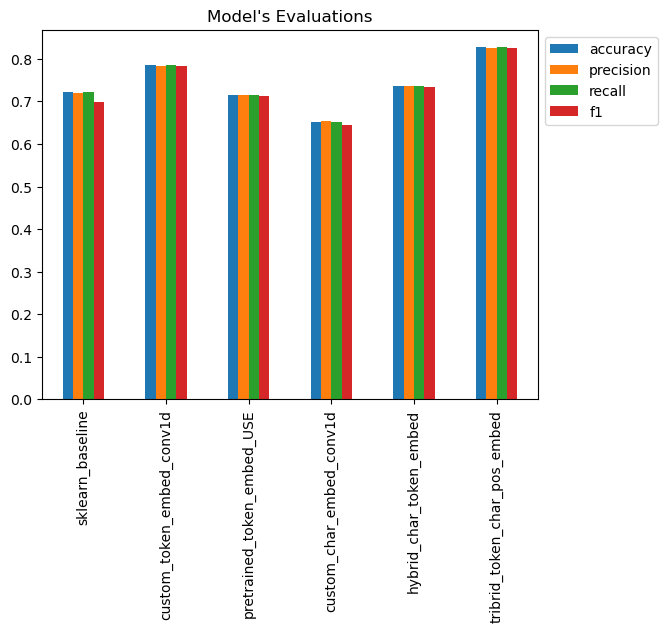

In [88]:
models_results.plot.bar();
plt.legend(bbox_to_anchor=(1, 1));
plt.title("Model's Evaluations");

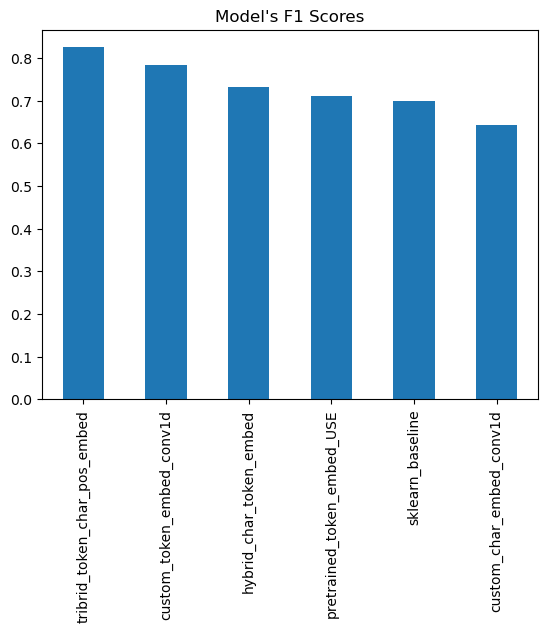

In [111]:
models_results.f1.sort_values(ascending=False).plot.bar();
plt.title("Model's F1 Scores");

## Evaluate Model 5 on test_data

In [90]:
model_5.evaluate(test_token_char_pos_dataset)
test_pred_probs = model_5.predict(test_token_char_pos_dataset)
test_preds = np.argmax(test_pred_probs, axis = 1)
model_5_test_results = calculate_results(test_labels_encoded, test_preds)

942/942 [==============================] - 18s 19ms/step


In [91]:
model_5_test_results

{'accuracy': 82.27642276422765,
 'precision': 0.8216055702866272,
 'recall': 0.8227642276422764,
 'f1': 0.8210884885192647}

### Save and load Model 5 using SavedModel format

In [92]:
model_5.save(filepath="model_5_SavedModel_format")
loaded_model_5 = tf.keras.models.load_model("model_5_SavedModel_format")

INFO:tensorflow:Assets written to: model_5_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_5_SavedModel_format/assets


## The most wrong predictions
- create a dataframe on model's incorrect predictions on the test data
- display model's top 10 incorrect predictions with high prediction probabilities

In [95]:
test_df["pred_prob"] = np.max(test_pred_probs, axis = 1)
test_df["prediction"] = class_names[np.argmax(test_pred_probs, axis = 1)]

In [96]:
most_wrong = test_df[test_df.target != test_df.prediction].sort_values(by = "pred_prob", ascending=False)
most_wrong.head(10)

,target,text,line_number,total_lines,pred_prob,prediction
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,0.917664,OBJECTIVE
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,0.915587,RESULTS
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,0.907085,METHODS
29294,RESULTS,"baseline measures included sociodemographics ,...",4,13,0.906195,METHODS
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,0.902385,METHODS
1221,RESULTS,data were collected prospectively for @ months...,3,13,0.899961,METHODS
6027,RESULTS,patients were randomized in a bayesian respons...,4,15,0.897010,METHODS
697,RESULTS,a screening questionnaire for moh was sent to ...,4,14,0.891989,METHODS
4593,METHODS,this study provides class ii evidence that reg...,11,11,0.891271,CONCLUSIONS
835,BACKGROUND,to assess the temporal patterns of late gastro...,0,11,0.890393,OBJECTIVE


## Predictions on an abstract from the wild 

In [97]:
custom_abstracts = get_lines("custom_abstracts/skimlit_example_abstracts.json")
# using get_lines function to read JSON file and store abstracts


abs_list = [] #empty list to store all numbered abstracts
abs_sentences = [] #empty list to store contents of individual abstract


for num, items in enumerate(custom_abstracts[0].split("abstract")):
    dict = {
       "abs_num": num,
       "abstract": items

    }
    
    abs_list.append(dict) 
    #loops and adds all abstacts with an assigned number
    
    
    
abstract_text = abs_list[1]["abstract"]

for num, sentence in enumerate(abstract_text.split(".")):
    dict = {
        
        "line_number": num,
        "total_lines": len(abstract_text.split(".")) - 6,
        "text": sentence
    }
    
    abs_sentences.append(dict)
    
    '''
    loops through specified abstract and stores each line as a dictionary 


    ex.  {'line_number': 0,
      'total_lines': 7,
      'text': '": "This RCT examined the efficacy of a manualized social intervention for children with HFASDs'}

    '''

### Create Dataframe to store abstract details

In [105]:
custom_abstract_df = pd.DataFrame(abs_sentences)
custom_abstract_df

,line_number,total_lines,text
0,0,7,""": ""This RCT examined the efficacy of a manual..."
1,1,7,Participants were randomly assigned to treatm...
2,2,7,Treatment included instruction and therapeuti...
3,3,7,A response-cost program was applied to reduce...
4,4,7,Significant treatment effects were found for ...
5,5,7,Secondary measures based on staff ratings (tr...
6,6,7,"High levels of parent, child and staff satisf..."
7,7,7,Standardized effect size estimates were prima...


### Transform data and predict using Model 5

In [108]:
custom_abs_line_num = tf.one_hot(custom_abstract_df.line_number, depth=15)
custom_abs_total_line = tf.one_hot(custom_abstract_df.total_lines, depth=20)
custom_abs_chars = [" ".join(list(sentence)) for sentence in custom_abstract_df.text]
custom_abs_sentence = [sentence for sentence in custom_abstract_df.text]

In [109]:
custom_abs_pred_probs = loaded_model_5.predict(x = (tf.constant(custom_abs_sentence),
                           tf.constant(custom_abs_chars),
                           custom_abs_line_num,
                           custom_abs_total_line
                          ))

1/1 [==============================] - 1s 885ms/step


### Insert Predictions into Custom Abstract Dataframe

In [110]:
custom_abstract_df["prediction"] = class_names[tf.argmax(custom_abs_pred_probs, axis= 1)]
custom_abstract_df

,line_number,total_lines,text,prediction
0,0,7,""": ""This RCT examined the efficacy of a manual...",OBJECTIVE
1,1,7,Participants were randomly assigned to treatm...,METHODS
2,2,7,Treatment included instruction and therapeuti...,METHODS
3,3,7,A response-cost program was applied to reduce...,METHODS
4,4,7,Significant treatment effects were found for ...,METHODS
5,5,7,Secondary measures based on staff ratings (tr...,METHODS
6,6,7,"High levels of parent, child and staff satisf...",RESULTS
7,7,7,Standardized effect size estimates were prima...,RESULTS
